## Harmonic Oscillator

In [1]:
import numpy as np

# importing Qiskit
from qiskit import QuantumCircuit, transpile, assemble, Aer, IBMQ,execute, QuantumRegister
from qiskit.utils import QuantumInstance
from qiskit.providers.ibmq import least_busy
from qiskit.tools.monitor import job_monitor
from qiskit.visualization import plot_histogram, plot_bloch_multivector
from qiskit import BasicAer
from qiskit.circuit import Gate
from qiskit.extensions import UnitaryGate
from math import ceil
import matplotlib.pyplot as plt

In [2]:
backend = BasicAer.get_backend('qasm_simulator')

In [3]:
def qft(qfc,m,n):
    i = n
    while i >= m :
        qfc.h(i)
        for j in range(m,i):
            qfc.cp(2*np.pi*1/(2**(i-j+1)),i,j)
        i-=1
    for k in range(m,(n+1+m)//2):
        qfc.swap(k,n+m-k)
    #qfc.barrier()
    return qfc

def inv_qft(iqfc,m,n):
    qf = qft(QuantumCircuit(n-m+1),m,n)
    iqf = qf.inverse()
    iqfc.compose(iqf,iqfc.qubits[m:n+1])
    return iqfc

def qpe(n,unitary,intial):
    qpc = QuantumCircuit(2*n,n)
    for i in range(n):
        qpc.h(i)
    qpc.initialize(initial,qpc.qubits[n:2*n])
    
    c_unitary = unitary.to_gate().control(1)
    
    for i in range(n):
        for j in range(2**(n-i)):
            qpc.append(c_unitary,[i]+[x for x in range(n,2*n)])
    
    inv_qft(qpc,0,n-1)
    
    for i in range(n):
        qpc.measure(i,i)
    return qpc
def iqpe(n,unitary,initial,k_precision):
    phase = 0
    for k in reversed(range(k_precision)):
        iqc = QuantumCircuit(n+1,1)
        iqc.h(0)
        iqc.initialize(initial,iqc.qubits[1:])
        #iqc.x(1)
        c_unitary = unitary.control(1)
        
        for order in range(2**k):
            iqc.append(c_unitary,iqc.qubits[:])
 
        phase_shift = 2*np.pi*phase*2**k
        iqc.p(-phase_shift,0)
        iqc.h(0)
        iqc.measure(0,0)
        
        job = execute(iqc, backend, shots=1000)
        result = job.result()
        counts = result.get_counts()
        value = int(max(counts, key=counts.get))
        
        phase += value / 2 ** (k + 1)
        
    return phase

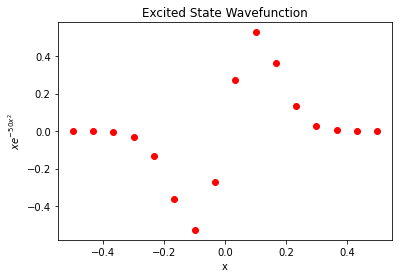

In [11]:
#DEFINE INITIAL WAVEFUNCTION

L = 0.5
n = 4 #number of qubits
x = np.linspace(-L, L, num=2**n) #number of x points

wvfunc = x*np.exp(-50*x**2) #Initial wavefunciton
Normalisation_Constant = np.sqrt(np.sum(wvfunc**2)) 
normalized_wvfunc = wvfunc / Normalisation_Constant ##Normalized initial wavefunction
plt.plot(x, normalized_wvfunc,'ro')
plt.ylabel('$x e^{-50 x^2}$')
plt.xlabel('x')
plt.title('Excited State Wavefunction')
plt.savefig('ho-excited-state.png')

In [5]:
#DEFINE PARAMETERS
n = 4
qubit_num = n #number of qubits
qubit_tot = 2**qubit_num #number of possible states
t = 0.03 #timestep
iteration = 20 #number of iteration
dt = t/iteration #time evolution
ALPHA = -(2*np.pi*qubit_tot)**2*dt
BETA  = ALPHA/2
0.03/20

0.0015

In [6]:
def constant_phase_beta(circuit):
    """
    Add constant phase to the circuit
    Args:
        circuit, register, number of qubits
    """
    i = 0 + 1j
    constant_phase_beta = np.array([[np.exp(i*BETA/4), 0], [0, np.exp(i*BETA/4)]])
    cp_gate = UnitaryGate(constant_phase_beta, 'Constant')
    circuit.append(cp_gate, [0])
    #circuit.barrier()
    
    return circuit

def rotate1_pot(circuit, n):
    """
    Add shift phase gate to the circuit
    Args:
        circuit, register, number of qubits
    """
    
    for m in range(n):
        theta = -BETA * 2**(m-n)
        circuit.p(theta, m)
        
    return circuit


def rotate2_pot(circuit,n):
    """
    Add constant phase to the circuit
    Args:
        circuit, register, number of qubits
    """
    
    for m in range(n):
        theta = BETA * 2**(2*(m-n))
        circuit.p(theta, m)
        
    return circuit

def potential(circuit, qubit):
    """
    Define energy potential operator
    Args:
        circuit, register, number of qubits
    Returns:
        Add energy potentials to the system
    """
    
    constant_phase_beta(circuit)
    rotate1_pot(circuit,qubit)
    rotate2_pot(circuit,qubit)
    
    n = np.arange(qubit-1, -1, -1, dtype=float)
    
    for i in n:
        for j in np.arange(i-1, -1, -1, dtype=float):
            kin = 2*BETA*2**(j + i - 2*(len(n)))
            circuit.cp(kin,int(j), int(i))
            
    return circuit

def constant_phase(circuit):
    """
    Add constant phase to the circuit
    Args:
        circuit, register, number of qubits
    """
    i = 0 + 1j
    constant_phase = np.array([[np.exp(i*ALPHA/4), 0], [0, np.exp(i*ALPHA/4)]])
    cp_gate = UnitaryGate(constant_phase, 'Constant')
    circuit.append(cp_gate, [0])
    #circuit.barrier()
    
    return circuit

def rotate1(circuit, n):
    """
    Add shift phase gate to the circuit
    Args:
        circuit, register, number of qubits
    """
    
    for m in range(n):
        theta = -ALPHA * 2**(m-n)
        circuit.p(theta, m)
        
    return circuit


def rotate2(circuit,n):
    """
    Add constant phase to the circuit
    Args:
        circuit, register, number of qubits
    """
    
    for m in range(n):
        theta = ALPHA * 2**(2*(m-n))
        circuit.p(theta, m)
        
    return circuit

def kinetic(circuit, qubit):
    """
    Define energy kinetic operator
    Args:
        circuit, register, number of qubits
    Returns:
        Add energy kinetics to the system
    """
    
    constant_phase(circuit)
    rotate1(circuit,qubit)
    rotate2(circuit,qubit)
    
    n = np.arange(qubit-1, -1, -1, dtype=float)
    
    for i in n:
        for j in np.arange(i-1, -1, -1, dtype=float):
            kin = 2*ALPHA*2**(j + i - 2*(len(n)))
            circuit.cp(kin,int(j), int(i))
            
    return circuit



In [7]:
def time_evolution(circuit,qubit_num):
    for i in range(iteration):
        #POTENTIAL
        potential(circuit,  qubit_num)
        #circuit.barrier()

        #QFT
        qft(circuit,0,qubit_num-1)
        #circuit.barrier()

        #KINETIC
        kinetic(circuit, qubit_num)
        #circuit.barrier()

        #INVERS QFT
        circuit = inv_qft(circuit,0,qubit_num-1)
        #circuit.barrier()


        #POTENTIAL
        potential(circuit,qubit_num)
        #circuit.barrier()
    return circuit


unitary = QuantumCircuit(4)
c_unitary = time_evolution(unitary,4).to_gate(label="Unitary").control(1)

In [14]:
theta = iqpe(4,unitary,normalized_wvfunc,5)

In [15]:
E = (theta)*2*np.pi/0.03 
print(f'Energy is {E}')
theta

Energy is 143.9896632895322


0.6875

In [8]:
unitary.draw()

┌──────────┐  ┌────────────┐┌──────────────┐                            »
q_0: ─┤ Constant ├──┤ P(0.47374) ├┤ P(-0.029609) ├───────────────■────────────»
     ┌┴──────────┴┐┌┴────────────┤└──────────────┘               │            »
q_1: ┤ P(0.94748) ├┤ P(-0.11844) ├─────────────────■─────────────┼────────────»
     └┬──────────┬┘├─────────────┤                 │             │            »
q_2: ─┤ P(1.895) ├─┤ P(-0.47374) ├───■─────────────┼─────────────┼────────────»
     ┌┴──────────┤ └┬───────────┬┘   │P(-1.895)    │P(-0.94748)  │P(-0.47374) »
q_3: ┤ P(3.7899) ├──┤ P(-1.895) ├────■─────────────■─────────────■────────────»
     └───────────┘  └───────────┘                                             »
«                                                                          »
«q_0: ───────────────■─────────────■─────────────■─────────────────────────»
«                    │             │P(-0.11844)  │                         »
«q_1: ─■─────────────┼─────────────■─────────────┼────────■────────────────»
«      │P(-0.47374)  │P(-0.23687)                │        │                »
«q_2: ─■─────────────■───────────────────────────┼────────┼────────■───────»
«         ┌───┐                                  │P(π/8)  │P(π/4)  │P(π/2) »
«q_3: ────┤ H ├──────────────────────────────────■────────■────────■───────»
«         └───┘                                                            »
«                                          ┌───┐    ┌──────────┐ ┌────────────┐»
«q_0: ──────■──────────────────────■───────┤ H ├─X──┤ Constant ├─┤ P(0.94748) ├»
«           │                ┌───┐ │P(π/2) └───┘ │  ├──────────┤┌┴────────────┤»
«q_1: ──────┼────────■───────┤ H ├─■─────────X───┼──┤ P(1.895) ├┤ P(-0.23687) ├»
«     ┌───┐ │P(π/4)  │P(π/2) └───┘           │   │ ┌┴──────────┤├─────────────┤»
«q_2: ┤ H ├─■────────■───────────────────────X───┼─┤ P(3.7899) ├┤ P(-0.94748) ├»
«     └───┘                                      │ ├───────────┤└┬────────────┤»
«q_3: ───────────────────────────────────────────X─┤ P(7.5799) ├─┤ P(-3.7899) ├»
«                                                  └───────────┘ └────────────┘»
«     ┌──────────────┐                                                      »
«q_0: ┤ P(-0.059218) ├─────────────■───────────────────────────■────────────»
«     └──────────────┘             │                           │            »
«q_1: ─────────────────■───────────┼─────────────■─────────────┼────────────»
«                      │           │             │P(-0.94748)  │P(-0.47374) »
«q_2: ──■──────────────┼───────────┼─────────────■─────────────■────────────»
«       │P(-3.7899)    │P(-1.895)  │P(-0.94748) ┌───────────┐ ┌───────────┐ »
«q_3: ──■──────────────■───────────■────────────┤ P(3.7899) ├─┤ P(-1.895) ├─»
«                                               └───────────┘ └───────────┘ »
«                     ┌──────────┐  ┌────────────┐┌──────────────┐»
«q_0: ─■──────────────┤ Constant ├──┤ P(0.47374) ├┤ P(-0.029609) ├»
«      │P(-0.23687)  ┌┴──────────┴┐┌┴────────────┤└──────────────┘»
«q_1: ─■─────────────┤ P(0.94748) ├┤ P(-0.11844) ├──■─────────────»
«      ┌──────────┐ ┌┴────────────┤└─────────────┘  │             »
«q_2: ─┤ P(1.895) ├─┤ P(-0.47374) ├───■─────────────┼─────────────»
«      └──────────┘ └─────────────┘   │P(-1.895)    │P(-0.94748)  »
«q_3: ────────────────────────────────■─────────────■─────────────»
«                                                                 »
«                                                               ┌──────────┐ »
«q_0: ─■───────────────────────────■─────────────■──────────────┤ Constant ├─»
«      │                           │             │P(-0.11844)  ┌┴──────────┴┐»
«q_1: ─┼─────────────■─────────────┼─────────────■─────────────┤ P(0.94748) ├»
«      │             │P(-0.47374)  │P(-0.23687)  ┌──────────┐ ┌┴────────────┤»
«q_2: ─┼─────────────■─────────────■─────────────┤ P(1.895) ├─┤ P(-0.47374) ├»
«      │P(-0.47374) ┌───────────┐ ┌───────────┐  └──────────┘ └─────────────